In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import pandas as pd
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)
import numpy as np
import matplotlib.pyplot as plt
from feature_manager import FeatureManager
from dnn_classifier import DNNClassifer
from random import randint
from keras import callbacks
from visualizer import *

2023-01-14 14:06:52.608524: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-01-14 14:06:52.608628: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2023-01-14 14:06:52.608641: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.


In [2]:
data = pd.read_csv("../data/BTCUSDT-1h.csv", parse_dates=["Open Time"], index_col = "Open Time")
fm: FeatureManager = FeatureManager()
fm.build_feature(data=data,lags=5)

tp = 0.15
sl = 0.05
md = 14

fm.prepare_trade_forward_data(
    data=fm.df,
    take_profit_rate=tp,
    stop_loss_rate=sl,
    max_duration=md)

In [ ]:
classifier = DNNClassifer(neg_cutoff=0.45,pos_cutoff=0.55,epochs=50,train_size=0.7,val_size=0.15)
classifier.configure(hl=2, hu = 100, dropout=True, input_dim=len(fm.cols), loss="mse")
classifier.prepare_data(data = fm.df,cols = fm.cols,random_state=randint(0,100),target_col="trade_signal")
classifier.run(gpu = False,patient=7)
classifier.model.evaluate(classifier.x_test,classifier.y_test)


======= Lap 1 =======
Train = 32779, Val = 7024, Test = 7025, All = 46828
Epoch 1/100

Epoch 1: val_loss improved from inf to 0.59387, saving model to ../data/model_dnn_checkpoint.h5
1025/1025 - 13s - loss: 1.0187 - accuracy: 0.2055 - val_loss: 0.5939 - val_accuracy: 0.0339 - 13s/epoch - 13ms/step
Epoch 2/100

Epoch 2: val_loss improved from 0.59387 to 0.55409, saving model to ../data/model_dnn_checkpoint.h5
1025/1025 - 6s - loss: 0.8951 - accuracy: 0.1202 - val_loss: 0.5541 - val_accuracy: 0.1589 - 6s/epoch - 6ms/step
Epoch 3/100

Epoch 3: val_loss improved from 0.55409 to 0.52458, saving model to ../data/model_dnn_checkpoint.h5
1025/1025 - 6s - loss: 0.8709 - accuracy: 0.2233 - val_loss: 0.5246 - val_accuracy: 0.2568 - 6s/epoch - 6ms/step
Epoch 4/100

Epoch 4: val_loss improved from 0.52458 to 0.46821, saving model to ../data/model_dnn_checkpoint.h5
1025/1025 - 6s - loss: 0.8532 - accuracy: 0.2975 - val_loss: 0.4682 - val_accuracy: 0.3662 - 6s/epoch - 6ms/step
Epoch 5/100

Epoch 5: 

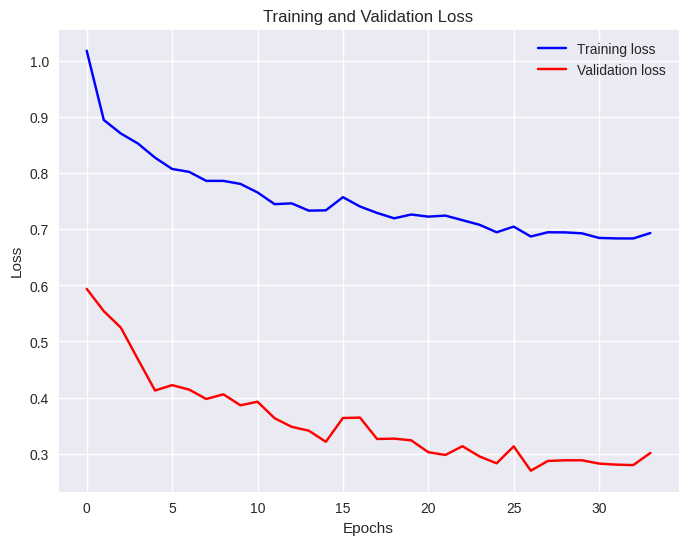

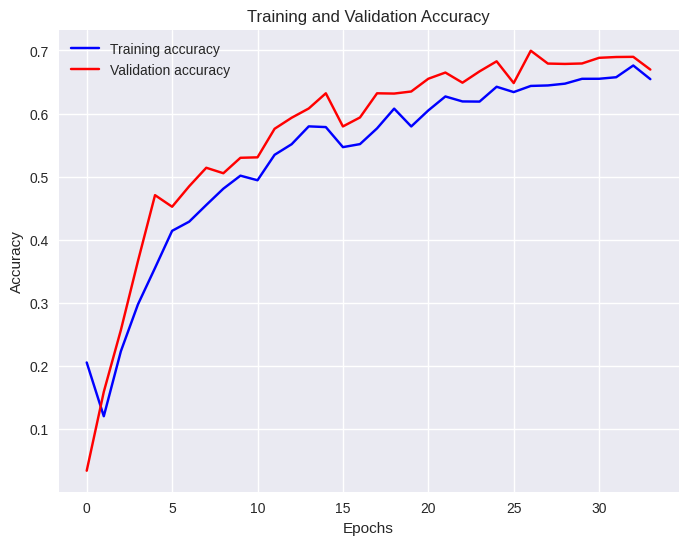

220/220 [==============================] - 1s 4ms/step - loss: 0.3005 - accuracy: 0.6705

======= Lap 2 =======
Train = 32779, Val = 7024, Test = 7025, All = 46828
Epoch 1/100

Epoch 1: val_loss improved from inf to 0.57780, saving model to ../data/model_dnn_checkpoint.h5
1025/1025 - 13s - loss: 1.0445 - accuracy: 0.2241 - val_loss: 0.5778 - val_accuracy: 0.0285 - 13s/epoch - 12ms/step
Epoch 2/100

Epoch 2: val_loss improved from 0.57780 to 0.53981, saving model to ../data/model_dnn_checkpoint.h5
1025/1025 - 6s - loss: 0.9128 - accuracy: 0.1134 - val_loss: 0.5398 - val_accuracy: 0.1371 - 6s/epoch - 6ms/step
Epoch 3/100

Epoch 3: val_loss improved from 0.53981 to 0.52708, saving model to ../data/model_dnn_checkpoint.h5
1025/1025 - 6s - loss: 0.8811 - accuracy: 0.1722 - val_loss: 0.5271 - val_accuracy: 0.2349 - 6s/epoch - 6ms/step
Epoch 4/100

Epoch 4: val_loss improved from 0.52708 to 0.44912, saving model to ../data/model_dnn_checkpoint.h5
1025/1025 - 6s - loss: 0.8575 - accuracy: 0.26

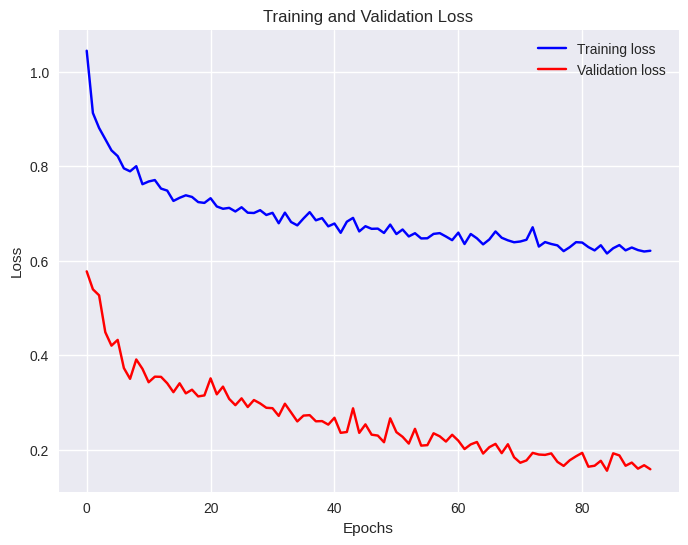

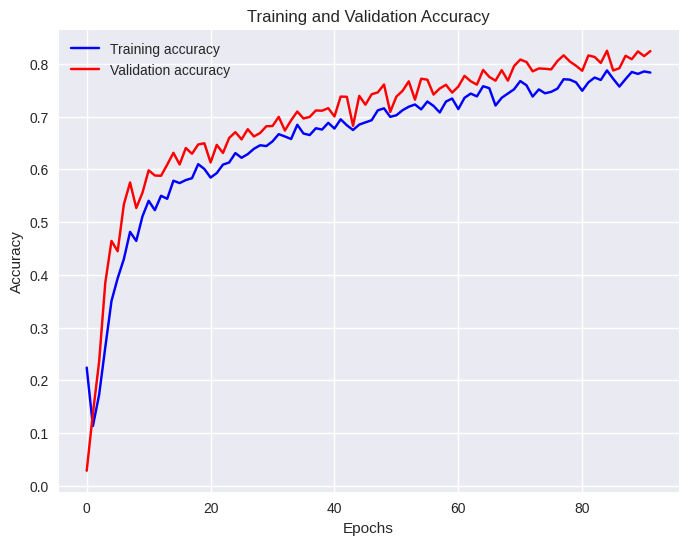

220/220 [==============================] - 1s 4ms/step - loss: 0.1546 - accuracy: 0.8309

======= Lap 3 =======
Train = 32779, Val = 7024, Test = 7025, All = 46828
Epoch 1/100

Epoch 1: val_loss improved from inf to 0.59959, saving model to ../data/model_dnn_checkpoint.h5
1025/1025 - 12s - loss: 1.0589 - accuracy: 0.2297 - val_loss: 0.5996 - val_accuracy: 0.0262 - 12s/epoch - 12ms/step
Epoch 2/100

Epoch 2: val_loss improved from 0.59959 to 0.54225, saving model to ../data/model_dnn_checkpoint.h5
1025/1025 - 6s - loss: 0.8900 - accuracy: 0.1276 - val_loss: 0.5423 - val_accuracy: 0.1602 - 6s/epoch - 6ms/step
Epoch 3/100

Epoch 3: val_loss improved from 0.54225 to 0.50575, saving model to ../data/model_dnn_checkpoint.h5
1025/1025 - 6s - loss: 0.8734 - accuracy: 0.2070 - val_loss: 0.5057 - val_accuracy: 0.2756 - 6s/epoch - 6ms/step
Epoch 4/100

Epoch 4: val_loss improved from 0.50575 to 0.46096, saving model to ../data/model_dnn_checkpoint.h5
1025/1025 - 6s - loss: 0.8592 - accuracy: 0.28

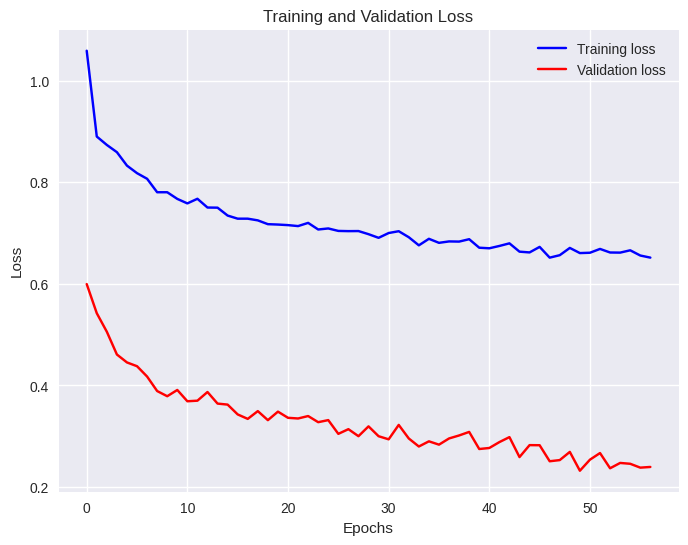

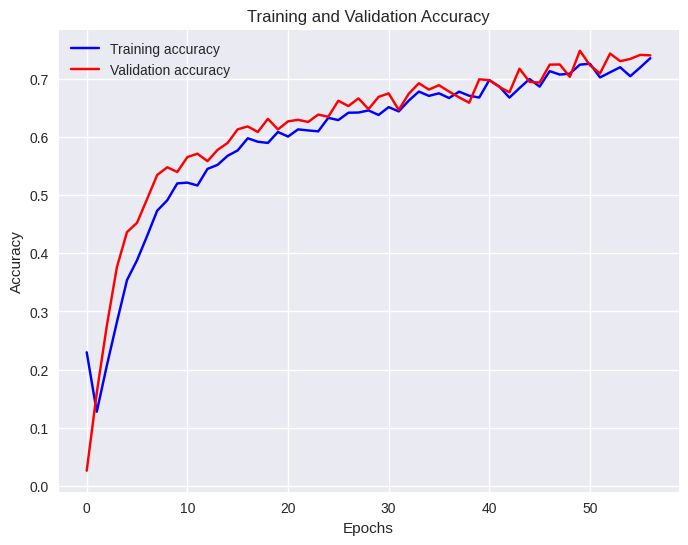

220/220 [==============================] - 1s 4ms/step - loss: 0.2461 - accuracy: 0.7340

Accuracy mean: 0.7451008359591166, std: 0.06596698989105144
Loss mean: 0.23374728361765543, std: 0.06022168810208324


In [4]:
acc_list = []
loss_list = []
laps = 3

for i in range (0,laps):
    print("\n======= Lap {} =======".format(i+1))
    callbacks.backend.clear_session()
    
    classifier = DNNClassifer(
        epochs=100,
    )
    
    classifier.configure(
        hl=2, 
        hu = 100, 
        dropout=True, 
        input_dim=len(fm.cols), 
        loss="mse"
    )
    
    classifier.prepare_data(
        data = fm.df,
        cols = fm.cols,
        shuffle = True, 
        random_state=i+1,
        target_col="trade_signal"
    )
    
    classifier.run(gpu = False,patient=7)
    classifier.visualize_loss()
    classifier.visualize_accuracy()
    
    test_results = classifier.model.evaluate(
        classifier.x_test,
        classifier.y_test
    )

    acc_list.append(test_results[1])
    loss_list.append(test_results[0])

acc_arr = np.array(acc_list)
loss_arr = np.array(loss_list)

print("\n======")
print("Accuracy mean: {}, std: {}".format(acc_arr.mean(),acc_arr.std()))
print("Loss mean: {}, std: {}".format(loss_arr.mean(),loss_arr.std()))
print("======")